## PyTorch autograd examples

In this example, we calculate transfer maps using PyTorch autograd Jacobian and compare times against numerical differentiation. We also calculate the gradient and the Hessian of the beamsize of a 10 quadrupole lattice with respect to the quadrupole strengths. 

In [1]:
import torch
import numpy as np

from bmadx import Particle, Drift, Quadrupole
from bmadx import track_element, track_lattice
from bmadx import M_ELECTRON


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # for high DPI displays in MacOS

torch.set_printoptions(precision= 8, sci_mode=True)

In [2]:
# Create torch particle beam
s = 0.0 # initial s
p0c = 4e7 # reference momentum in eV

# Initial beam distribution
n_particles = 10_000 # number of particles in beam
coords = np.random.multivariate_normal(mean = np.zeros(6),
                                       cov = 1e-6*np.identity(6),
                                       size = n_particles
                                      )
beam_np = Particle(*coords.T, s=s, p0c=p0c, mc2=M_ELECTRON)

beam_torch = Particle(*torch.tensor(coords.T),
                      s=torch.tensor(s),
                      p0c=torch.tensor(p0c),
                      mc2=torch.tensor(M_ELECTRON))

In [3]:
# Tracking though element takes incoming particle coordinate
# type (i.e., torch tensor in this case) for the tracking regarldless
# the element parameter types.
q = Quadrupole(L=0.1, K1=10.0)
track_element(beam_torch, q)

Particle(x=tensor([-1.25225321e-03, -8.07424511e-04, 1.01876566e-03,  ..., 3.14815575e-04,
        7.30047047e-04, -4.30266518e-04], dtype=torch.float64), px=tensor([ 1.67690112e-03,  3.79699912e-03, -2.39973309e-06,  ...,
         1.22896346e-03, -9.94924684e-04,  7.55091668e-04],
       dtype=torch.float64), y=tensor([-1.91838819e-03, -1.11080845e-03, -8.93557784e-04,  ..., 5.56683897e-04,
        2.71718125e-04, -8.95613244e-04], dtype=torch.float64), py=tensor([-1.87924923e-03, -1.69813336e-03, -1.92315820e-03,  ..., 1.55781221e-03,
        5.18011374e-04, -3.35959076e-03], dtype=torch.float64), z=tensor([-1.68730509e-04, -1.13614145e-03, 8.20609520e-04,  ..., 1.57025761e-03,
        1.27056731e-04, -3.85550378e-04], dtype=torch.float64), pz=tensor([-4.57659916e-04,  1.79299543e-04,  5.37571494e-05,  ...,
        -1.11078089e-04,  9.66857930e-04,  9.56573788e-04],
       dtype=torch.float64), s=tensor(1.00000000e-01, dtype=torch.float64), p0c=tensor(4.00000000e+07), mc2=tensor( 5.1

In [4]:
# we can use PyTorch autograd to calculate derivatives

# calculate Jacobian around 0 through quadrupole:
# define tracking as function of 6d coordinates:
f_quadrupole_torch = lambda coord: track_element(Particle(*coord,
                                                    s = torch.tensor(s),
                                                    p0c = torch.tensor(p0c),
                                                    mc2 = torch.tensor(M_ELECTRON)), 
                                                 q)[:6]
f_quadrupole_np = lambda coord: np.array(track_element(Particle(*coord,
                                                                s = s,
                                                                p0c = p0c,
                                                                mc2 = M_ELECTRON), 
                                                       q)[:6])

In [5]:
import torch.autograd.functional as ad

In [6]:
%%time
# Jacobian evaluated at 0 using pytorch autograd:
J_ad = ad.jacobian(f_quadrupole_torch, torch.zeros(6))
J_ad = torch.vstack(J_ad)
J_ad

CPU times: user 4.25 ms, sys: 602 µs, total: 4.85 ms
Wall time: 41.8 ms


tensor([[ 9.50415313e-01,  9.83416438e-02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-9.83416438e-01,  9.50415313e-01, -0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.05041802e+00,  1.01675019e-01,
          0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  1.01675022e+00,  1.05041802e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  1.63173318e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00]])

In [7]:
import numdifftools as nd

In [8]:
%%time
# Jacobian evaluated at 0 using numerical differentiation:
J_nd = nd.Jacobian(f_quadrupole_np)(np.zeros(6))
J_nd

CPU times: user 6.8 ms, sys: 0 ns, total: 6.8 ms
Wall time: 6.49 ms


array([[ 9.50415280e-01,  9.83416469e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.83416469e-01,  9.50415280e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.05041806e+00,
         1.01675020e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.01675020e+00,
         1.05041806e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.63173324e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [9]:
# calculate gradient of beamsize with respect to quadrupole strengths:

# fixed parameters:
half_drift = Drift(L=0.9/2) # half drift
L_q = 0.1 # quad length

def beamsize(beam_in, quad_strengths):
    """Function of beamsize with respect to quad strengths"""
    # create lattice of len(quad_strengths) quadrupoles separated by drifts:
    lattice = [] # initialize lattice
    for k1 in quad_strengths:
        lattice.append( half_drift )
        lattice.append( Quadrupole(L=L_q, K1=k1) )
        lattice.append( half_drift )
        
    beam_out = track_lattice(beam_in, lattice)
    return beam_out.x.std()

beamsize_torch = lambda k1s: beamsize(beam_torch, k1s)
beamsize_np = lambda k1s: beamsize(beam_np, k1s)

In [10]:
%%time
# calculate gradient of beamsize with respect to quad strengths using torch autograd:
grad_ad = ad.jacobian(beamsize_torch, torch.zeros(10))
grad_ad

CPU times: user 38.2 ms, sys: 22.2 ms, total: 60.4 ms
Wall time: 57.2 ms


tensor([-5.10116515e-04, -1.30567828e-03, -1.90016499e-03, -2.29357649e-03, -2.48591299e-03,
        -2.47717439e-03, -2.26736045e-03, -1.85647164e-03, -1.24450761e-03, -4.31468536e-04])

In [11]:
%%time
# calculate gradient of beamsize with respect to quad strengths using numerical diff:
grad_nd = nd.Jacobian(beamsize_np)(np.zeros(10))
grad_nd

CPU times: user 2.83 s, sys: 1.95 ms, total: 2.83 s
Wall time: 2.83 s


array([[-0.00056046, -0.00135598, -0.00195044, -0.00234383, -0.00253616,
        -0.00252742, -0.00231762, -0.00190675, -0.00129481, -0.00048181]])

In [12]:
%%time
# calculate Hessian of beamsize with respect to quad strengths using torch autograd:
hes_ad = ad.hessian(beamsize_torch, torch.zeros(10))
hes_ad

CPU times: user 377 ms, sys: 162 ms, total: 539 ms
Wall time: 510 ms


tensor([[7.93902436e-05, 1.04608960e-04, 1.25891893e-04, 1.38137868e-04,
         1.41346885e-04, 1.35518931e-04, 1.20654004e-04, 9.67521191e-05,
         6.38132697e-05, 2.18374571e-05],
        [1.04608960e-04, 5.08812955e-05, 1.43219382e-04, 2.19118650e-04,
         2.65522336e-04, 2.82430381e-04, 2.69842829e-04, 2.27759665e-04,
         1.56180889e-04, 5.51065059e-05],
        [1.25891893e-04, 1.43219382e-04, 3.08434755e-05, 1.71229054e-04,
         2.80701031e-04, 3.40257742e-04, 3.49899201e-04, 3.09625379e-04,
         2.19436304e-04, 7.93319559e-05],
        [1.38137868e-04, 2.19118650e-04, 1.71229054e-04, 1.74048328e-05,
         1.86882986e-04, 3.09001014e-04, 3.60823091e-04, 3.42349260e-04,
         2.53579492e-04, 9.45138017e-05],
        [1.41346885e-04, 2.65522336e-04, 2.80701031e-04, 1.86882986e-04,
         8.92736261e-06, 1.88660182e-04, 3.02614557e-04, 3.25931323e-04,
         2.58610467e-04, 1.00652047e-04],
        [1.35518931e-04, 2.82430381e-04, 3.40257742e-04, 3.0

In [13]:
%%time
# calculate Hessian of beamsize with respect to quad strengths using numerical diff:
hes_nd = nd.Hessian(beamsize_np)(np.zeros(10))
hes_nd

CPU times: user 28.6 s, sys: 5.82 ms, total: 28.6 s
Wall time: 28.6 s


array([[8.11763540e-05, 1.13636661e-04, 1.37923838e-04, 1.52169231e-04,
        1.56372840e-04, 1.50534667e-04, 1.34654710e-04, 1.08732969e-04,
        7.27694454e-05, 2.67641383e-05],
       [1.13636661e-04, 5.53194588e-05, 1.59193985e-04, 2.37089498e-04,
        2.84485604e-04, 3.01382303e-04, 2.87779595e-04, 2.43677481e-04,
        1.69075960e-04, 6.39750332e-05],
       [1.37923838e-04, 1.59193985e-04, 3.72631690e-05, 1.92140555e-04,
        3.02601817e-04, 3.62145037e-04, 3.70770218e-04, 3.28477359e-04,
        2.35266459e-04, 9.11375195e-05],
       [1.52169231e-04, 2.37089498e-04, 1.92140555e-04, 2.51356239e-05,
        2.10721479e-04, 3.32822871e-04, 3.83626579e-04, 3.63132602e-04,
        2.71340942e-04, 1.08251597e-04],
       [1.56372840e-04, 2.84485604e-04, 3.02601817e-04, 2.10721479e-04,
        1.72989008e-05, 2.13415803e-04, 3.26348676e-04, 3.47643211e-04,
        2.77299408e-04, 1.15317266e-04],
       [1.50534667e-04, 3.01382303e-04, 3.62145037e-04, 3.32822871e-04,
   

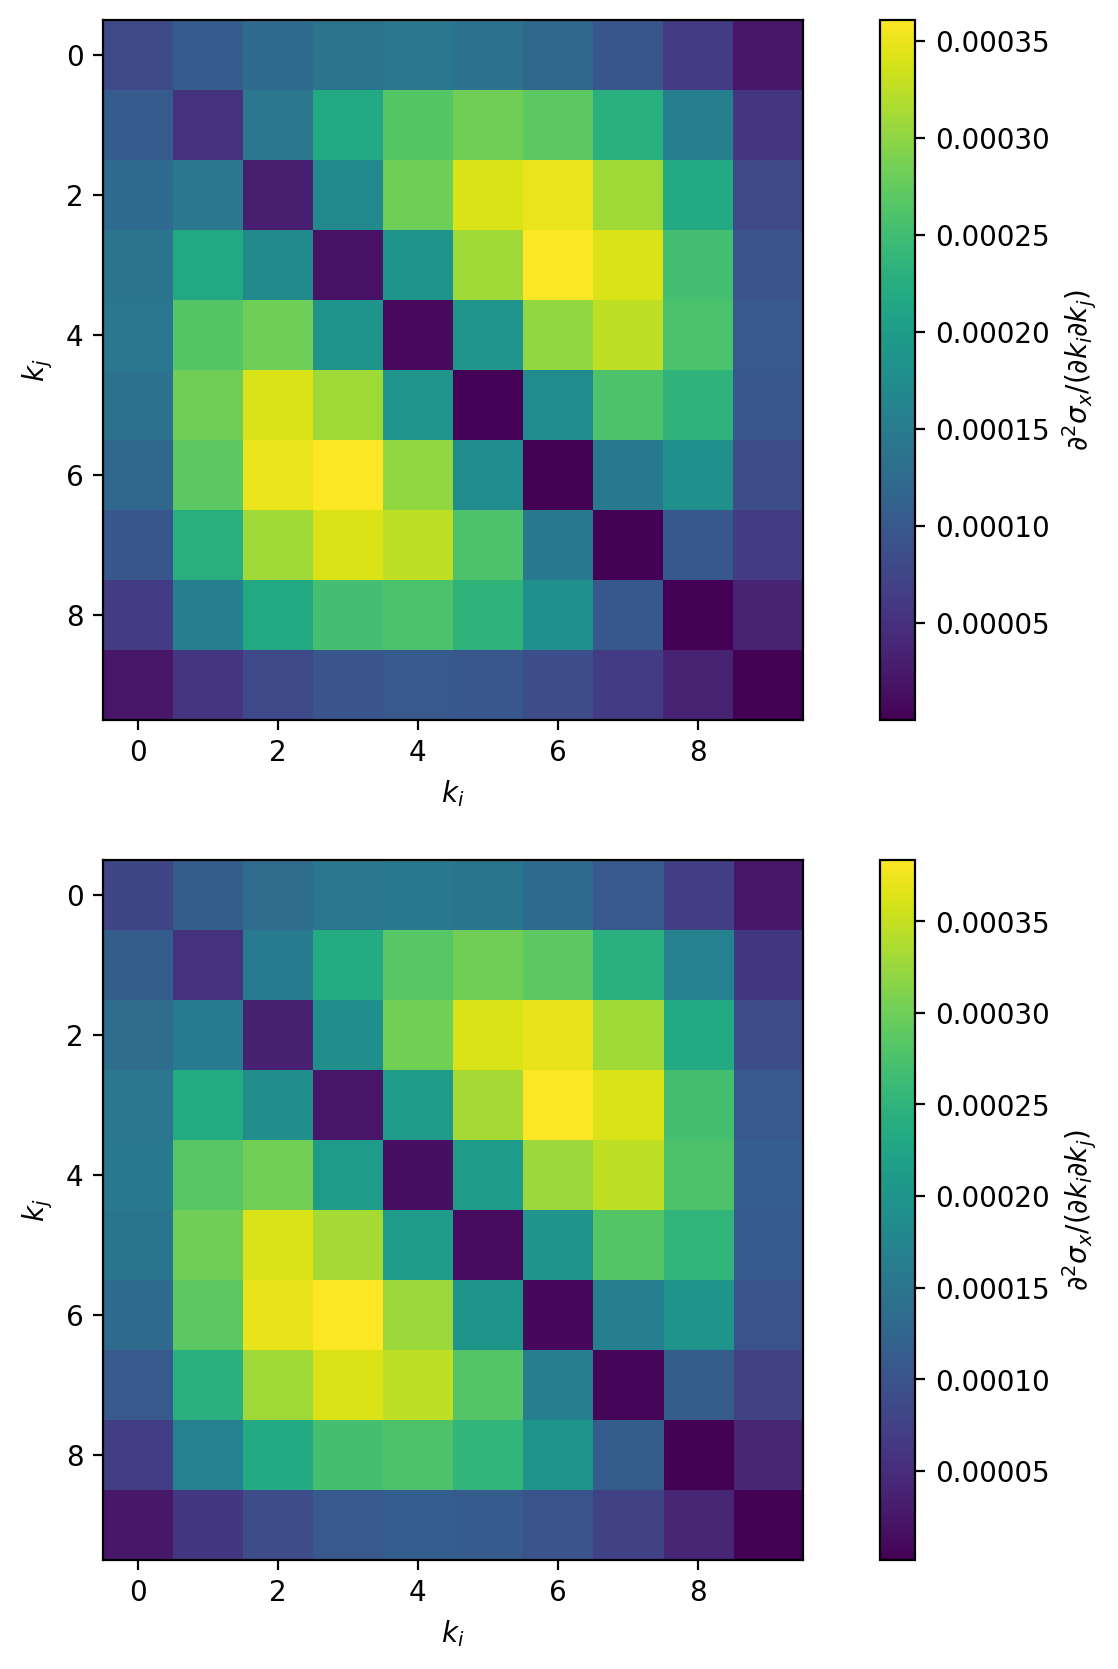

In [14]:
fig, axs = plt.subplots(2, figsize=(10,10))
cm = axs[0].imshow(hes_ad.detach().numpy())
axs[0].set_xlabel(r'$k_i$')
axs[0].set_ylabel(r'$k_j$')
fig.colorbar(cm,ax=axs[0], label=r'$\partial^2 \sigma_x / (\partial k_i \partial k_j)$')
cm = axs[1].imshow(hes_nd)
axs[1].set_xlabel(r'$k_i$')
axs[1].set_ylabel(r'$k_j$')
fig.colorbar(cm,ax=axs[1], label=r'$\partial^2 \sigma_x / (\partial k_i \partial k_j)$')